<a href="https://www.kaggle.com/code/putuwidyantara/simple-ocr" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>

## Install Packages

In [1]:
!pip install -q imutils

## Import Packages

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image

import cv2
import imutils
import matplotlib.pyplot as plt
from string import ascii_uppercase, digits
from sklearn.model_selection import train_test_split

## Load Dataset

In [3]:
df  = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")

## Data Preprocessing

In [4]:
# Rename column and convert to NumPy arrays
df.rename(columns={'0': 'label'}, inplace=True)
X = df.drop('label', axis=1).to_numpy()
y = df['label'].to_numpy()

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load MNIST dataset and reshape
(X_train_number, y_train_number), (X_test_number, y_test_number) = tf.keras.datasets.mnist.load_data()

# Reshape both datasets in a single step
X_train_number = X_train_number.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test_number = X_test_number.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Adjust y labels for your custom dataset
y_train += 10
y_test += 10

# Concatenate training and test datasets
X_train_combined = np.concatenate((X_train, X_train_number), axis=0)
X_test_combined = np.concatenate((X_test, X_test_number), axis=0)

# Concatenate labels and apply one-hot encoding
y_train_combined = np.concatenate((y_train, y_train_number), axis=0)
y_test_combined = np.concatenate((y_test, y_test_number), axis=0)

y_train_combined = tf.keras.utils.to_categorical(y_train_combined)
y_test_combined = tf.keras.utils.to_categorical(y_test_combined)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model

In [5]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(28,28,1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(36, activation="softmax"),  # 36 outputs: 0-9 and A-Z
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(
    X_train_combined,
    y_train_combined,
    epochs=3,
    batch_size=64,
    validation_data=(X_test_combined, y_test_combined),
)

Epoch 1/3
5594/5594 ━━━━━━━━━━━━━━━━━━━━ 185s 33ms/step - accuracy: 0.8748 - loss: 0.4538 - val_accuracy: 0.9714 - val_loss: 0.1025
Epoch 2/3
5594/5594 ━━━━━━━━━━━━━━━━━━━━ 183s 33ms/step - accuracy: 0.9700 - loss: 0.1012 - val_accuracy: 0.9788 - val_loss: 0.0755
Epoch 3/3
5594/5594 ━━━━━━━━━━━━━━━━━━━━ 186s 33ms/step - accuracy: 0.9779 - loss: 0.0732 - val_accuracy: 0.9823 - val_loss: 0.0626


## Evaluation

In [6]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_combined, y_test_combined, verbose=2)
print(f'Test accuracy: {test_acc}')

2641/2641 - 20s - 7ms/step - accuracy: 0.9823 - loss: 0.0626
Test accuracy: 0.9823174476623535


## Predict Single Image

In [11]:
label_names = digits+ascii_uppercase
labels = {idx:label for idx, label in enumerate(label_names)}

In [113]:
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = img_array.reshape((28, 28, 1))
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_single_image(image_path) -> str:
    img_array = load_and_preprocess_image(image_path)
    processed_image = load_and_preprocess_image(image_path)
    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction)
    return labels[predicted_class]

pred = predict_single_image("/kaggle/input/exampleimage/huruf-p.png")
print(f"Prediction: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction: P


## Character Recognition

In [109]:
def get_ocr(file_name):
    image_path = file_name

    image_to_test = cv2.imread(image_path)
    gray = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edge = cv2.Canny(blur, 30, 150)
    cntrs = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = imutils.grab_contours(cntrs)

    # Sort contours from top-left to bottom-right
    bbox = [cv2.boundingRect(contour) for contour in cntrs]
    # Sort contours from left to right, then top to bottom
    cntrs = [c for c, _ in sorted(zip(cntrs, bbox), key=lambda item: (item[1][0], item[1][1]))]
    
    char_detected = []
    # Iterate over contours
    for c in cntrs:
        (x, y, w, h) = cv2.boundingRect(c)

        # Ignore small contours based on width and height
        if 10 <= w <= 350 and 15 <= h <= 350:
            # Extract Region of Interest (ROI)
            roi = gray[y:y+h, x:x+w]

            # Apply binary thresholding to get a binary image
            bin_img = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
            (iH, iW) = bin_img.shape

            # Resize to maintain aspect ratio based on the larger dimension (scale factor)
            scale_factor = 28.0 / max(iW, iH)
            new_size = (int(iW * scale_factor), int(iH * scale_factor))
            bin_img = cv2.resize(bin_img, new_size)

            # Calculate padding to fit the image into 28x28 size
            dX = (28 - new_size[0]) // 2
            dY = (28 - new_size[1]) // 2

            # Pad the image with black (0) and ensure size is 28x28
            padded = cv2.copyMakeBorder(bin_img, dY, dY, dX, dX, cv2.BORDER_CONSTANT, value=0)
            padded = cv2.resize(padded, (28, 28))  # Ensure it's exactly 28x28 if padding is uneven

            # Normalize the image to [0, 1] and reshape to match model input (28, 28, 1)
            padded = np.expand_dims(padded.astype('float32') / 255.0, axis=-1)

            # Append the detected character and its bounding box to the list
            char_detected.append([padded, (x, y, w, h)])

    # Extract bounding boxes and detected characters
    boxes = [b[1] for b in char_detected]
    char_images = np.array([c[0] for c in char_detected], dtype="float32")

    # Predict characters using the model
    predictions = model.predict(char_images)

    # Process predictions
    preds = [(labels[np.argmax(pred)], np.max(pred)) for pred in predictions]

    # Annotate image with predictions
    for (pred, (x, y, w, h)) in zip(preds, boxes):
        label, prob = pred
        cv2.rectangle(image_to_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image_to_test, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Save the result image
    cv2.imwrite("/kaggle/working/result.jpg", image_to_test)
    return [{"prediction": labels[np.argmax(pred)], "probabilty": np.max(pred)} for pred in predictions]

In [110]:
get_ocr("/kaggle/input/exampleimage/b34kp.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[{'prediction': 'B', 'probabilty': 0.9270971},
 {'prediction': '3', 'probabilty': 0.9648179},
 {'prediction': '4', 'probabilty': 0.90743756},
 {'prediction': 'K', 'probabilty': 0.9999721},
 {'prediction': 'P', 'probabilty': 0.999241}]

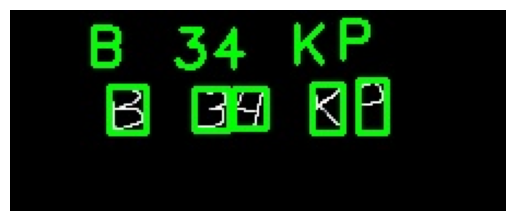

In [111]:
image_path = '/kaggle/working/result.jpg'
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [114]:
model.save("simple_ocr.keras")